In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import torch.autograd as Variable
from torch.utils.data import DataLoader, TensorDataset
import tqdm
import time
import torch

In [80]:
!pip install  category_encoders
!pip install pandas==1.5.3
!pip install dcor

In [81]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
path_to_module = '/content/gdrive/MyDrive/Orange/DataPreparation'
sys.path.append(path_to_module)
from cleaner import read_data
from helpers import convey_insights
path_to_module = '/content/gdrive/MyDrive/Orange/'
sys.path.append(path_to_module)
from utils import nice_table
path_to_module = '/content/gdrive/MyDrive/Orange/ModelPipelines'
sys.path.append(path_to_module)
from ModelAnalysis import evaluate

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [82]:
x_data, y_data=read_data(split="train")

In [83]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn



# Now use this loss function in your training loop


In [84]:
# class Net(nn.Module):
#   def __init__(self,in_count,out_count, *args, **kwargs) -> None:
#     super(Net, self).__init__(*args, **kwargs)
#     self.fc1 = nn.Linear(in_count, 512) # in
#     self.fc2 = nn.Linear(512, 256)
#     self.fc3 = nn.Linear(256, 128)
#     self.fc4 = nn.Linear(128, 64)
#     self.fc5 = nn.Linear(64, 32)
#     self.fc6 = nn.Linear(32, 16)
#     self.fc7 = nn.Linear(16, 8)
#     self.fc8 = nn.Linear(8, 4)
#     self.fc9 = nn.Linear(4, 1) # out: 1

#   def forward(self,x):
#     x= f.relu(self.fc1(x))
#     x= f.relu(self.fc2(x))
#     x= f.relu(self.fc3(x))
#     x= f.relu(self.fc4(x))
#     x= f.relu(self.fc5(x))
#     x= f.relu(self.fc6(x))
#     x= f.relu(self.fc7(x))
#     x= f.relu(self.fc8(x))
#     return  torch.sigmoid(self.fc9(x))

class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, out_count)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


In [85]:
class EarlyStopping:
    def __init__(self, patience=150, delta=0.1):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [86]:
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data, test_size=0.25 , random_state=42 )
x_train= torch.tensor(x_train.values).float()
y_train= torch.tensor(y_train.values).float()
x_test= torch.tensor(x_test.values).float()
y_test= torch.tensor(y_test.values).float()

In [87]:
BATCH_SIZE = 1000
dataset_train = TensorDataset(x_train,y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test,y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
model = Net(x_train.shape[1], 1).to(device)

y_data_numpy = y_train.cpu().numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_data_numpy)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device) # convert weights to tensor
# Define BCEWithLogitsLoss with pos_weight for class imbalance problem
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

early_stopping = EarlyStopping(patience=100, delta=0.01)

cuda


In [88]:
# training

epoch = 0
done = False
train=[]
validation=[]
while epoch<1000 and not done:
  epoch+=1
  steps =list(enumerate(dataloader_train))
  pbar =tqdm.tqdm(steps)
  model.train()

  for i, (x_batch , y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device)).flatten()
    # y_batch_pred = (y_batch_pred >= 0.5).float()
    loss = loss_fn(y_batch_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item() , (i+1)*len(x_batch)

    if i == len(steps)-1:
      model.eval()
      pred= model(x_test.to(device)).flatten()
      vloss = loss_fn(pred, y_test.to(device))
      train.append(loss)
      validation.append(vloss.item())
      early_stopping(vloss, model)
      done=early_stopping.early_stop
      pbar.set_description(f"Epoch: {epoch}, tloss:{loss} , vloss{vloss} , done{done}")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss:{loss}")



Epoch: 1, tloss:0.588085412979126 , vloss0.5951558351516724 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 189.90it/s]
Epoch: 2, tloss:0.5610812306404114 , vloss0.5890739560127258 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 236.77it/s]
Epoch: 3, tloss:0.5812103748321533 , vloss0.5834099054336548 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 229.71it/s]
Epoch: 4, tloss:0.5945624113082886 , vloss0.5803499817848206 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 203.21it/s]
Epoch: 5, tloss:0.5917953848838806 , vloss0.5788260102272034 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 245.40it/s]
Epoch: 6, tloss:0.5779826045036316 , vloss0.5776327252388 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 206.17it/s]
Epoch: 7, tloss:0.5690516233444214 , vloss0.5763655304908752 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 173.01it/s]
Epoch: 8, tloss:0.5824786424636841 , vloss0.575599193572998 , doneFalse: 100%|██████████| 31/31 [00:00<00:00, 121.11it/s]
Epoch: 9, tloss:0.578

In [100]:
import pickle
def save(name, data):
    '''
    Given model name and model, it saves the model.
    '''
    with open(f'./{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [101]:
save("Neural_Networks", model)
save("errors",[train, validation])

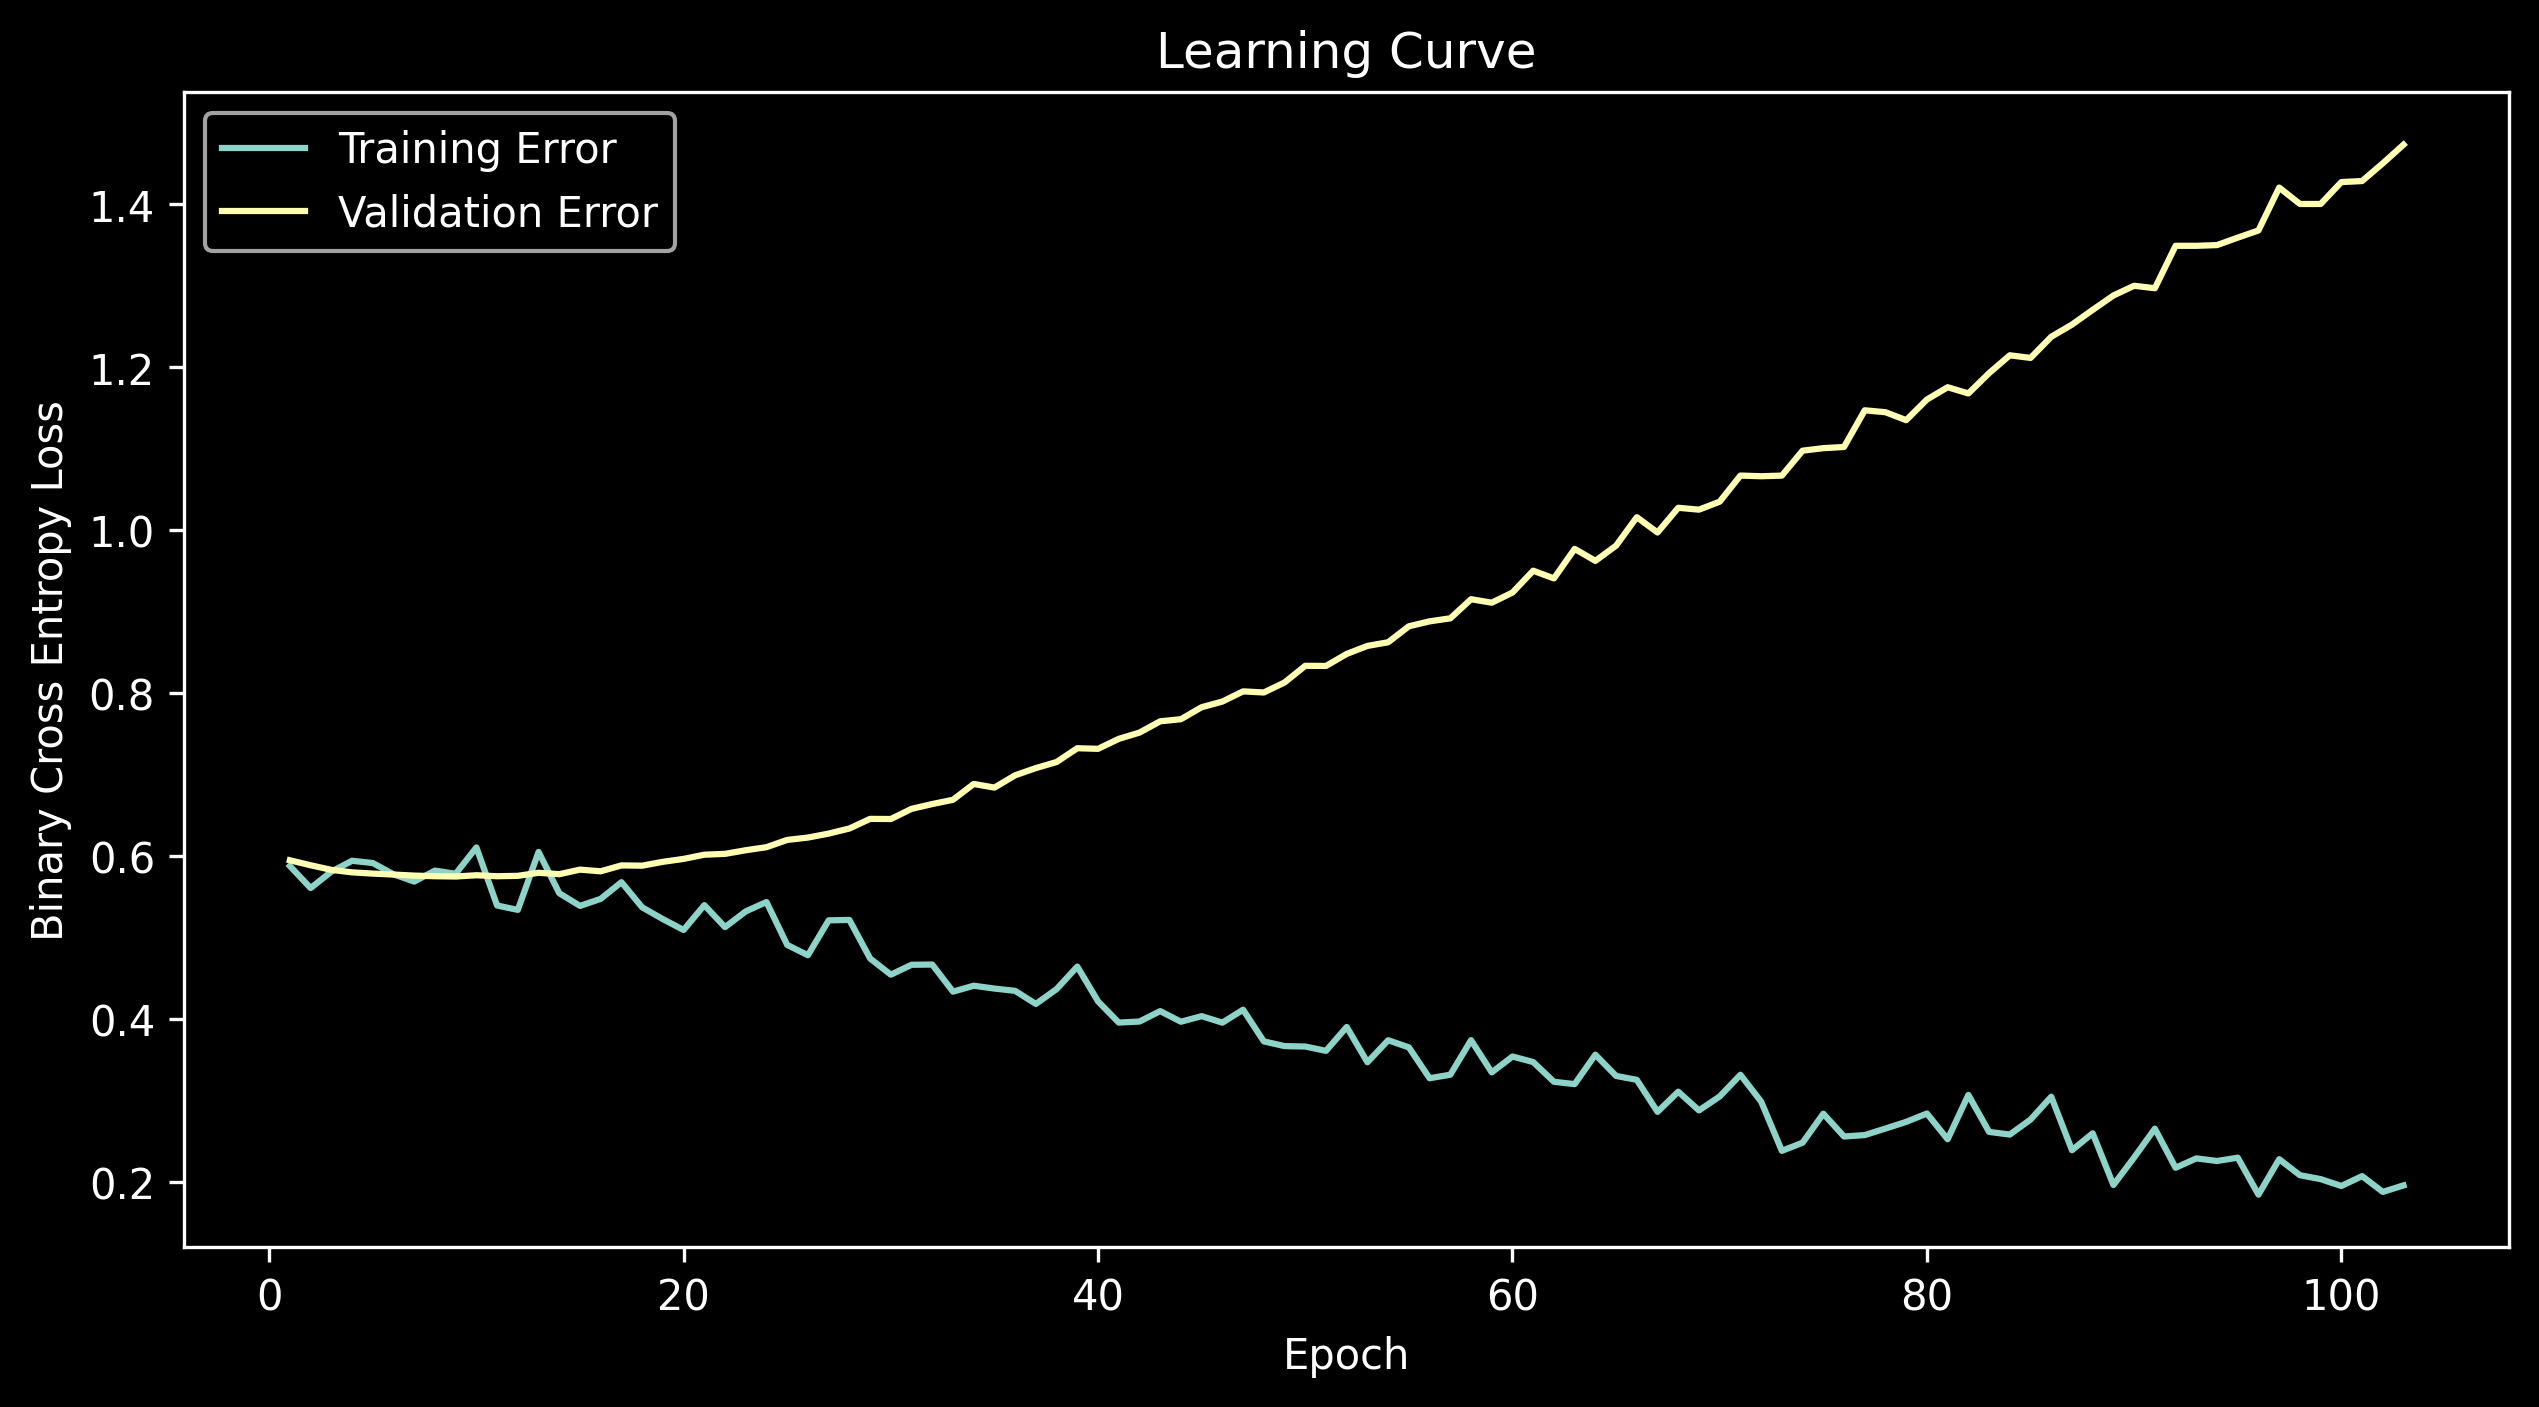

In [91]:
import matplotlib.pyplot as plt
epochs=list(range(1,len(train)+1))
plt.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("Learning Curve")
plt.plot(epochs, train, markersize=5, label='Training Error' )
plt.plot(epochs, list(validation), markersize=5, label='Validation Error' )
plt.legend(loc="best")
plt.show()

In [92]:
def predict(model,x):
  x=torch.tensor(x.values).float()
  return model(x.to(device))

In [93]:
x_train, y_train=read_data(split="train")
x_test, y_test=read_data(split="test")


y_train_pred=predict(model,x_train)
y_test_pred= predict(model,x_test)

In [94]:
y_train_pred = (y_train_pred >= 0.5).float()
y_test_pred = (y_test_pred >= 0.5).float()


y_train_pred=y_train_pred.cpu().data.numpy()
y_test_pred = y_test_pred.cpu().data.numpy()




In [99]:
save("Predictions",{"train":y_train_pred, "test":y_test_pred})

'test:y_test_pred})' was not found in history, as a file, url, nor in the user namespace.


In [97]:
_=evaluate(y_train, y_train_pred, "Training Evals",table=True)
_=evaluate(y_test, y_test_pred, "Testing Evals", table=True)
convey_insights([
    "The Neural Network is unable to give much better results than RandomForest",
    "It is either extremely overfitting or underfitting with no sweet spot reached.",
    "The final model is extremely obvious to be a case of overfitting"

])

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.85812,0.75483,0.74917,0.75199,0.82558


Accuracy,Precision,Recall,F1 Score,ROC AUC
0.64349,0.35966,0.28064,0.31527,0.53705


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> The Neural Network is unable to give much better results than RandomForest<br><br><font color="pink">✦</font> It is either extremely overfitting or underfitting with no sweet spot reached.<br><br><font color="pink">✦</font> The final model is extremely obvious to be a case of overfitting<br><br></font>